# Project 3: Perfect Vine Compilation
## Group 7
### Hayley Carney, Rohan Enagala, Stephen Jennings, Basil Mullings, Utkarsh Karki, Sandeep Sonawane

## Imports and Installs

In [35]:
#TODO Add in import statements as needed
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from pathlib import Path
from PIL import Image

In [36]:
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [52]:
#TODO Add data to repo for easy read in


##Basil
THUMBNAIL_BASE_DIR = Path('E:/UtKnox/Courses/Fall_2025/COSC545 - Digital Archeology/Module_7/Team Project/Data/thumbs')
INPUT_JSONL_FILE = 'E:/UtKnox\Courses/Fall_2025/COSC545 - Digital Archeology/Module_7/Team Project/Data/vine_embeddings_plus.jsonl'

##Hayley
#THUMBNAIL_BASE_DIR = Path('/Users/hayleygoldblatt/Documents/cosc545/m7_p3_perfect_vine_compilation/Data/thumbs')
#INPUT_JSONL_FILE = '/Users/hayleygoldblatt/Documents/cosc545/m7_p3_perfect_vine_compilation/Data/vine_embeddings_plus.jsonl'

#N_CLUSTERS = 5000
N_CLUSTERS = 50
RANDOM_STATE = 41
RANDOM_SEED = 41
FIG_SIZE = (12, 10)
DOT_SIZE = 1

## Helper Functions

In [38]:
def display_video_thumbnails(df_or_ids, max_images=25, columns=5, title="Selected Videos"):
    """
    Retrieves and displays thumbnail images for a list of videos.

    Args:
        df_or_ids (pd.DataFrame or list/pd.Series): 
            Either a DataFrame containing 'video_id_short' or a list/Series 
            of 'video_id_short' strings.
        max_images (int): The maximum number of images to display. Defaults to 25.
        columns (int): The number of columns in the display grid. Defaults to 5.
        title (str): The title for the plot. Defaults to "Selected Videos".
    """
    
    # --- 1. Determine the list of short IDs ---
    if isinstance(df_or_ids, pd.DataFrame):
        if 'video_id_short' not in df_or_ids.columns:
            print("❌ Error: DataFrame must contain the 'video_id_short' column.")
            return
        # Use the IDs from the DataFrame (e.g., if you pass df_data[:10])
        short_ids = df_or_ids['video_id_short'].tolist()
        
    elif isinstance(df_or_ids, (list, pd.Series)):
        # Use the list or Series directly (e.g., if you pass short_ids_list)
        short_ids = list(df_or_ids) 
        
    else:
        print("❌ Error: Input must be a DataFrame, list, or pandas Series of IDs.")
        return

    if not short_ids:
        print("📦 Found 0 IDs to display.")
        return


    num_found = len(short_ids)
    print(f"📦 Found {num_found} IDs. Displaying first {min(num_found, max_images)}.")
    
    # Limit the number of IDs to display
    ids_to_display = short_ids[:max_images]
    num_to_display = len(ids_to_display)
    
    # Calculate rows needed for the grid display
    rows = (num_to_display + columns - 1) // columns
    
    # 2. Setup the plot grid
    plt.figure(figsize=(columns * 3, rows * 3))
    plt.suptitle(f"Thumbnails for: {title}", fontsize=16)
    # print(",".join(short_ids)) # Optionally removed this large print

    # 3. Iterate through IDs and display images
    for i, video_id in enumerate(ids_to_display):
        # Construct the full path
        image_path = THUMBNAIL_BASE_DIR / f"{video_id}.png"
        
        plt.subplot(rows, columns, i + 1)
        
        # Determine the ID string to display in the title
        displayed_id = video_id            
        try:
            # Load and display the image
            img = Image.open(image_path)
            plt.imshow(img)

            # Use the possibly censored ID for the title
            plt.title(f"{displayed_id}", fontsize=8) 
            plt.axis('off') # Hide axis ticks and labels
            
        except FileNotFoundError:
            plt.title("Missing", fontsize=8, color='red')
            plt.text(0.5, 0.5, "Image Not Found", ha='center', va='center', color='red')
            plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
    plt.show()

In [39]:
def load_embeddings(jsonl_path):
    """
    Loads embeddings, filenames, and video_id_short from the JSONL file, 
    ensures consistent shape, and mean-pools any (16, D) time-series 
    embeddings to (D,).
    
    Returns: (DataFrame with 'filename', 'embedding', 'video_id_short', 
              list of numpy arrays)
    """
    data = []
    skipped_count = 0
    expected_shape = None
    print(f"Loading data from {jsonl_path}...")
    
    raw_data = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if line.strip():
                    item = json.loads(line)
                    raw_data.append({
                        'filename': item['filename'],
                        # 🔑 FIX: Extract the video_id_short field
                        'video_id_short': item.get('video_id_short', None),
                        'whisper_transcript': item.get('whisper_transcript', None),
                        'embedding': np.array(item['embedding'], dtype=np.float32)
                    })
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error during file read: {e}")
        return pd.DataFrame(), []

    if not raw_data:
        print("No data found in the input file.")
        return pd.DataFrame(), []

    for item in raw_data:
        current_embedding = item['embedding']
        # filename = item['filename'] # Not needed here, but kept in item
        
        if current_embedding.size == 0:
            skipped_count += 1
            continue

        if current_embedding.ndim == 2 and current_embedding.shape[0] == 16:
            current_embedding = np.mean(current_embedding, axis=0)
            item['embedding'] = current_embedding

        if expected_shape is None:
            expected_shape = current_embedding.shape
            data.append(item)
        elif current_embedding.shape == expected_shape:
            data.append(item)
        else:
            skipped_count += 1
            
    # Note: df now includes 'video_id_short'
    df = pd.DataFrame(data)
    embeddings = list(df['embedding'].values)

    print(f"Successfully loaded {len(embeddings)} consistent embeddings (Skipped {skipped_count} invalid/inconsistent entries).")
    return df, embeddings

In [40]:
from scipy.spatial.distance import cdist


def generate_nn_cluster(df_data, search_video_id, N_neighbors=25):
    """
    Finds the N closest neighbors in embedding space to a specified video ID
    and returns a DataFrame containing only those neighbors, ordered by closeness.

    Args:
        df_data (pd.DataFrame): DataFrame containing 'embedding' and 'video_id_short'.
        search_video_id (str): The 'video_id_short' of the seed video.
        N_neighbors (int): The number of closest videos to retrieve.

    Returns:
        pd.DataFrame: A DataFrame of the N closest neighbors, ordered by distance,
                      with a temporary 'cluster' ID for plotting functions.
    """
    if 'embedding' not in df_data.columns or 'video_id_short' not in df_data.columns:
        print("❌ Error: DataFrame must contain 'embedding' and 'video_id_short' columns.")
        return pd.DataFrame()

    # Find the embedding of the seed video
    search_row = df_data[df_data['video_id_short'] == search_video_id]
    
    if search_row.empty:
        print(f"❌ Error: Search video ID '{search_video_id}' not found in DataFrame.")
        return pd.DataFrame()

    # Convert all embeddings to a single matrix (X)
    X_embeddings = np.stack(df_data['embedding'].values)
    # The embedding for the search video (vector q)
    q_embedding = np.stack(search_row['embedding'].values)

    # Calculate the Euclidean distance (L2 norm) between the seed embedding (q) 
    # and every other embedding (X). cdist returns an array of shape (1, N).
    # We use metric='cosine' as it's often better for high-dimensional embeddings, 
    # but 'euclidean' (L2) is also common. Let's use 'euclidean' for simplicity here.
    distances = cdist(q_embedding, X_embeddings, metric='euclidean').flatten()

    # Create a Series with distances and the original DataFrame index
    distance_series = pd.Series(distances, index=df_data.index)

    # Get the indices of the N smallest distances (nearest neighbors)
    # The first one (distance=0) should be the search video itself.
    nearest_indices = distance_series.nsmallest(N_neighbors).index

    # Create the neighbor list, ordered by distance
    nn_df = df_data.loc[nearest_indices].copy()

    # 🔑 CRITICAL: Assign a temporary, unique 'cluster' ID (e.g., 9999) 
    # so the image generator function can filter correctly.
    nn_df['cluster'] = 9999 

    # Add distance column and sort explicitly
    nn_df['distance'] = distance_series.loc[nearest_indices]
    nn_df = nn_df.sort_values(by='distance')
    
    print(f"✅ Found {len(nn_df)} nearest neighbors for {search_video_id}.")
    return nn_df

In [43]:
##Manual Niche Exploration Helper.
##We’ll make a helper to inspect random examples from a cluster so we can pick a niche.

import textwrap

def sample_cluster_examples(df: pd.DataFrame, cluster_id: int, n: int = 10, random_seed: int = RANDOM_SEED):
    """
    Print sample metadata (and transcripts) from a given cluster.

    Args:
        df: Full DataFrame containing 'cluster_id'.
        cluster_id: Which cluster to inspect.
        n: Number of random examples to show.
    """
    subset = df[df["cluster_id"] == cluster_id]
    print(f"Cluster {cluster_id} contains {len(subset)} videos.")
    if len(subset) == 0:
        return

    n = min(n, len(subset))
    subset = subset.sample(n, random_state=random_seed)

    for i, row in subset.iterrows():
        print("=" * 80)
        print(f"Index: {i}")
        print(f"video_id_short: {row['video_id_short']}")
        print(f"filename: {row['filename']}")
        lang = row.get("whisper_language", None)
        if lang:
            print(f"whisper_language: {lang}")
        transcript = row.get("whisper_transcript", "")
        if isinstance(transcript, str) and transcript.strip():
            wrapped = textwrap.fill(transcript, width=70)
            print("whisper_transcript:")
            print(wrapped)
        else:
            print("whisper_transcript: [None]")
            

# # Example: explore a few clusters manually
# for cid in cluster_summary.head(10)["cluster_id"]:
#     print(f"\n\n>>> SAMPLE FROM CLUSTER {cid}")
#     sample_cluster_examples(df, cluster_id=cid, n=5)




In [44]:
def build_embedding_matrix(df: pd.DataFrame, embedding_col: str = "embedding") -> np.ndarray:
    """
    Build a 2D array (N, D) from a DataFrame column of 1D numpy arrays.

    Args:
        df: DataFrame with an 'embedding' column.
        embedding_col: Name of the column containing np.ndarray vectors.

    Returns:
        embeddings_matrix: np.ndarray of shape (N, D)
    """
    embeddings = df[embedding_col].values
    # Assume all vectors have same dimension D
    mat = np.stack(embeddings, axis=0)
    print(f"Embedding matrix shape: {mat.shape} (N, D)")
    return mat


def plot_histogram(data, title: str, xlabel: str, bins: int = 50):
    """
    Simple helper to plot a histogram.
    """
    plt.figure()
    plt.hist(data, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [45]:
df_data, embeddings_list = load_embeddings(INPUT_JSONL_FILE)

Loading data from E:/UtKnox\Courses/Fall_2025/COSC545 - Digital Archeology/Module_7/Team Project/Data/vine_embeddings_plus.jsonl...
Successfully loaded 28339 consistent embeddings (Skipped 0 invalid/inconsistent entries).


In [46]:
df_data.head()

,filename,video_id_short,whisper_transcript,embedding
0,20130626125209_182352F6-CFF3-497C-9891-8FF7D18...,182352F6-C,All DOGROUND... ALL DOGROUND... Call ohmd,"[-0.031610012, 0.03581158, 0.031906445, 0.0145..."
1,20130627194331_18C3F6CB-6E8C-4DD1-A245-CCA4CF2...,18C3F6CB-6,"Baby, Baby!","[-0.02479268, 0.029688096, 0.028634664, 0.0226..."
2,20130628013622_14CF3EAD-D4F8-4174-885A-27A2D49...,14CF3EAD-D,How are you? Great Bob! We're all in a little ...,"[-0.015824113, 0.033187184, 0.01681333, 0.0065..."
3,20130628211747_18112C4B-742F-4745-ACB1-C76F89A...,18112C4B-7,,"[-0.024460625, 0.03128573, 0.0068606776, 0.033..."
4,20130702110757_0AC9933B-F979-4A43-BB29-89C0C05...,0AC9933B-F,None,"[-0.026678782, 0.03043931, 0.0365816, 0.024619..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28339 entries, 0 to 28338
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   filename            28339 non-null  object
 1   video_id_short      28339 non-null  object
 2   whisper_transcript  20192 non-null  object
 3   embedding           28339 non-null  object
dtypes: object(4)
memory usage: 885.7+ KB
None
Embedding matrix shape: (28339, 768) (N, D)
Embedding norms - min / max / mean:
0.9999998 1.0000001 1.0


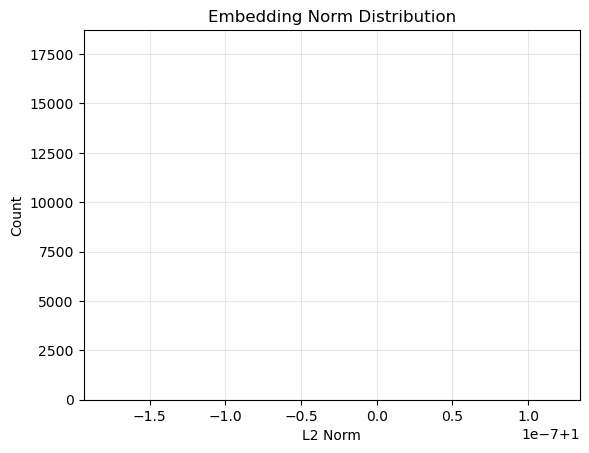

In [47]:
# Quick info about the dataset
print(df_data.info())
#print("\nSample rows:")
#display(df_data[["video_id_short", "filename", "whisper_transcript"]].head())


# Build embedding matrix and inspect norms
X = build_embedding_matrix(df_data, embedding_col="embedding")

# Compute L2 norms as a sanity check
norms = np.linalg.norm(X, axis=1)
print("Embedding norms - min / max / mean:")
print(norms.min(), norms.max(), norms.mean())

plot_histogram(norms, title="Embedding Norm Distribution", xlabel="L2 Norm", bins=50)

## Data Preprocessing
https://medium.com/@evgen.ryzhkov/5-stages-of-data-preprocessing-for-k-means-clustering-b755426f9932

In [ ]:
#TODO remove vines with swears/inappropriate content

# from better_profanity import profanity
# profanity.load_censor_words()
# df_data['profanity'] = df_data['whisper_transcript'].fillna('').apply(
#     lambda x: profanity.contains_profanity(x)
# )
# df_data = df_data[df_data['profanity'] == False].reset_index(drop=True)


from profanity_check import predict
df_data['profanity_score'] = predict(df_data['whisper_transcript'].fillna(''))
df_data = df_data[df_data['profanity_score'] == 0].reset_index(drop=True)
df_data.shape

In [ ]:
#TODO filter to niche topics



## Clustering Analysis
https://medium.com/@RobuRishabh/clustering-text-data-with-k-means-and-visualizing-with-t-sne-9bc1fe7d8fed

In [48]:
# Expand the 'Features' column into new columns
expanded_features = df_data['embedding'].apply(pd.Series)

# Optionally, rename the new columns for clarity
expanded_features.columns = [f'embedding_{i+1}' for i in range(expanded_features.shape[1])]

# Concatenate the expanded features with the original DataFrame (excluding the original list column)
df_expanded = pd.concat([expanded_features], axis=1)


In [49]:
df_expanded.head()

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,embedding_768
0,-0.031610,0.035812,0.031906,0.014598,-0.037266,0.023161,-0.002574,-0.031405,0.012062,-0.055055,...,-0.024395,0.019522,0.049779,-0.027164,-0.020035,-0.095322,-0.004795,0.015109,0.012812,0.036391
1,-0.024793,0.029688,0.028635,0.022613,-0.040009,0.026508,-0.002295,-0.036946,0.018670,-0.050425,...,-0.026428,0.027089,0.050627,-0.026537,-0.019204,-0.097297,-0.001054,0.014319,0.007215,0.031497
2,-0.015824,0.033187,0.016813,0.006594,-0.023289,0.032709,-0.022123,-0.035444,0.014615,-0.044755,...,-0.041138,0.017483,0.061825,-0.018192,-0.021996,-0.082239,-0.009018,0.034478,0.018713,0.033017
3,-0.024461,0.031286,0.006861,0.033299,-0.037236,0.015712,0.001993,-0.025504,0.020557,-0.051506,...,-0.024206,0.040424,0.035380,-0.027134,-0.021946,-0.101082,0.002300,0.028146,0.000513,0.034151
4,-0.026679,0.030439,0.036582,0.024620,-0.039549,0.024891,0.000604,-0.035731,0.015495,-0.054270,...,-0.020595,0.026193,0.048427,-0.030858,-0.024733,-0.101732,-0.000976,0.010061,0.003600,0.031207


📦 Found 10 IDs. Displaying first 10.


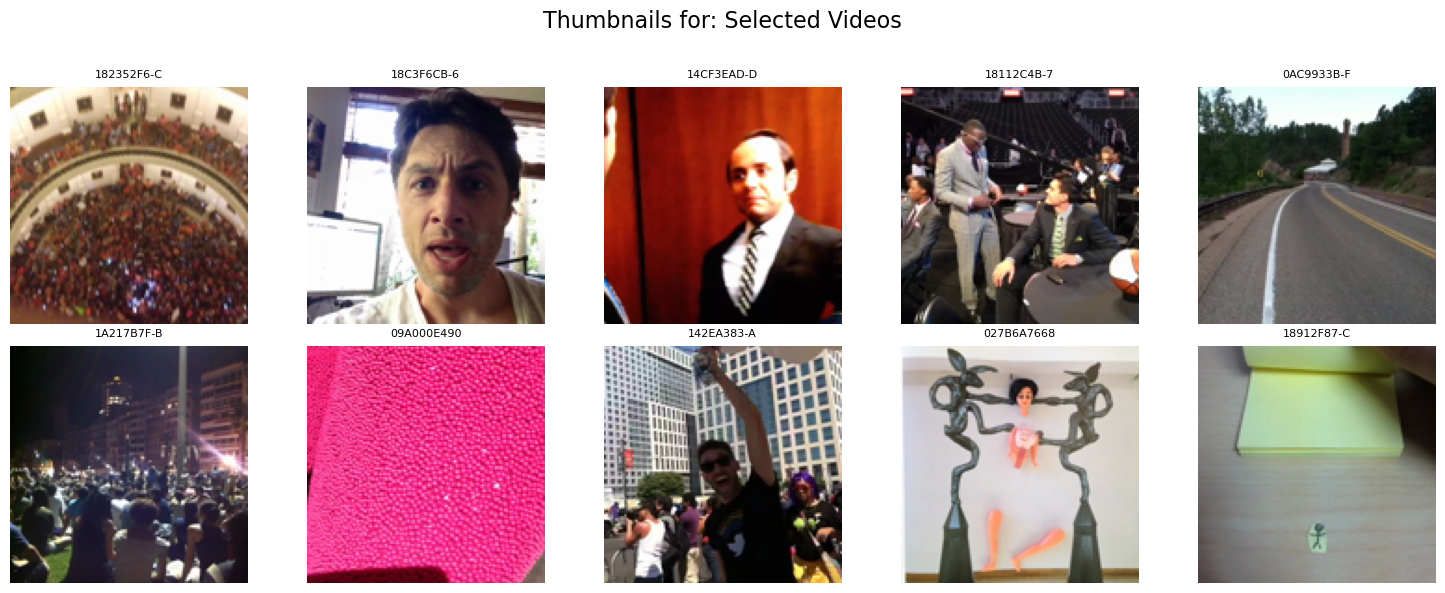

In [50]:
display_video_thumbnails(df_data[:10])

K=1000, Inertia=71.88551330566406
K=2000, Inertia=55.5911979675293
K=3000, Inertia=46.45094299316406
K=4000, Inertia=39.98889923095703
K=5000, Inertia=35.011505126953125
K=6000, Inertia=30.774993896484375
K=7000, Inertia=27.16421127319336
K=8000, Inertia=24.10123634338379
K=9000, Inertia=21.392446517944336
K=10000, Inertia=18.994020462036133


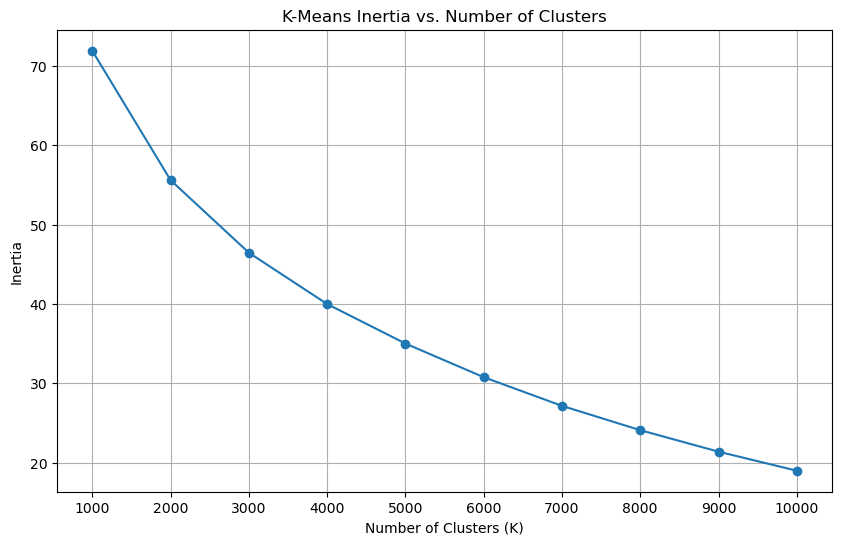

In [ ]:
#TODO perform K-Means with multiple k values to find optimal number of clusters and plot inertia values

###RUNTIME is > 100 minutes.

inertia_values = []
k_values = range(1000, 10001, 1000) 
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(df_expanded)
    inertia_values.append(kmeans.inertia_)
    print(f"K={k}, Inertia={kmeans.inertia_}")

# Plot the inertia values to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('K-Means Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()


In [54]:
#TODO perform K-Means with optimal number of clusters
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(df_expanded)
cluster_labels = kmeans.labels_

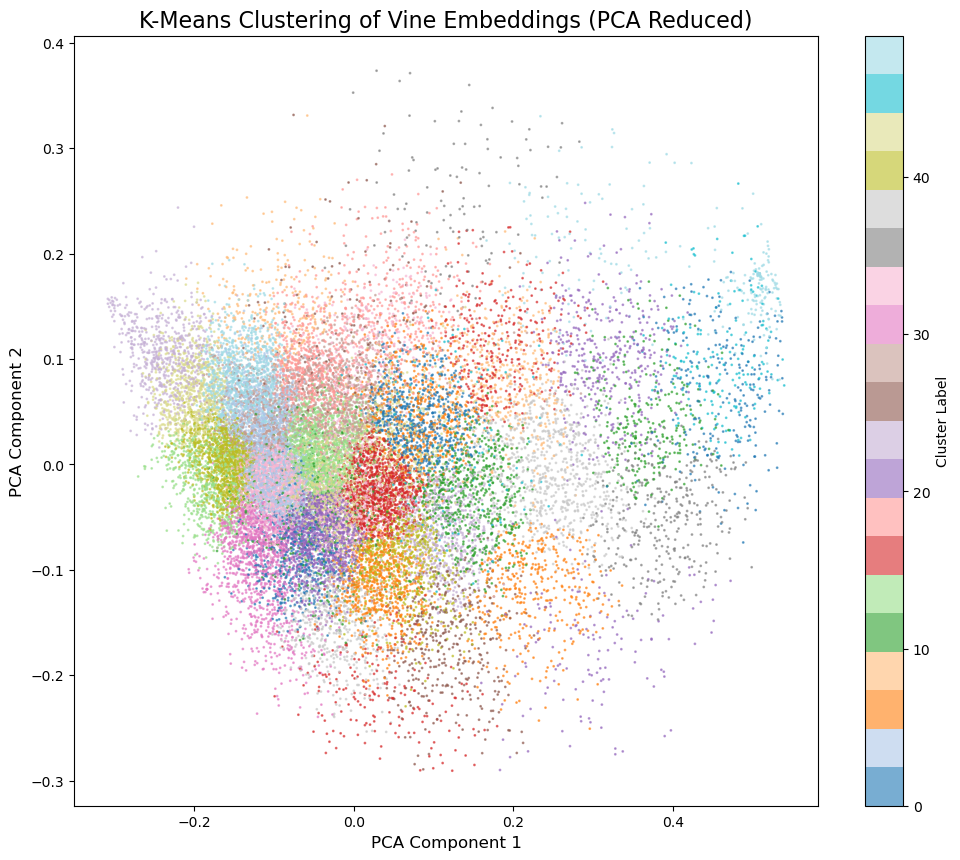

In [57]:
#TODO Visualize K-Means clusters with t-SNE
pca = PCA(n_components=2, random_state=RANDOM_STATE)
reduced_data = pca.fit_transform(df_expanded)  
df_reduced = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
df_reduced['cluster'] = cluster_labels
df_reduced.head()
plt.figure(figsize=FIG_SIZE)
scatter = plt.scatter(df_reduced['PCA1'], df_reduced['PCA2'], c=df_reduced['cluster'], s=DOT_SIZE, cmap='tab20', alpha=0.6)
plt.title('K-Means Clustering of Vine Embeddings (PCA Reduced)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(scatter, label='Cluster Label')
plt.show()

In [ ]:
#TODO DBSCAN clustering approach

###RUNTIME is > 40 minutes.

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5.0, min_samples=10, n_jobs=-1)
dbscan.fit(df_expanded)
dbscan_labels = dbscan.labels_  

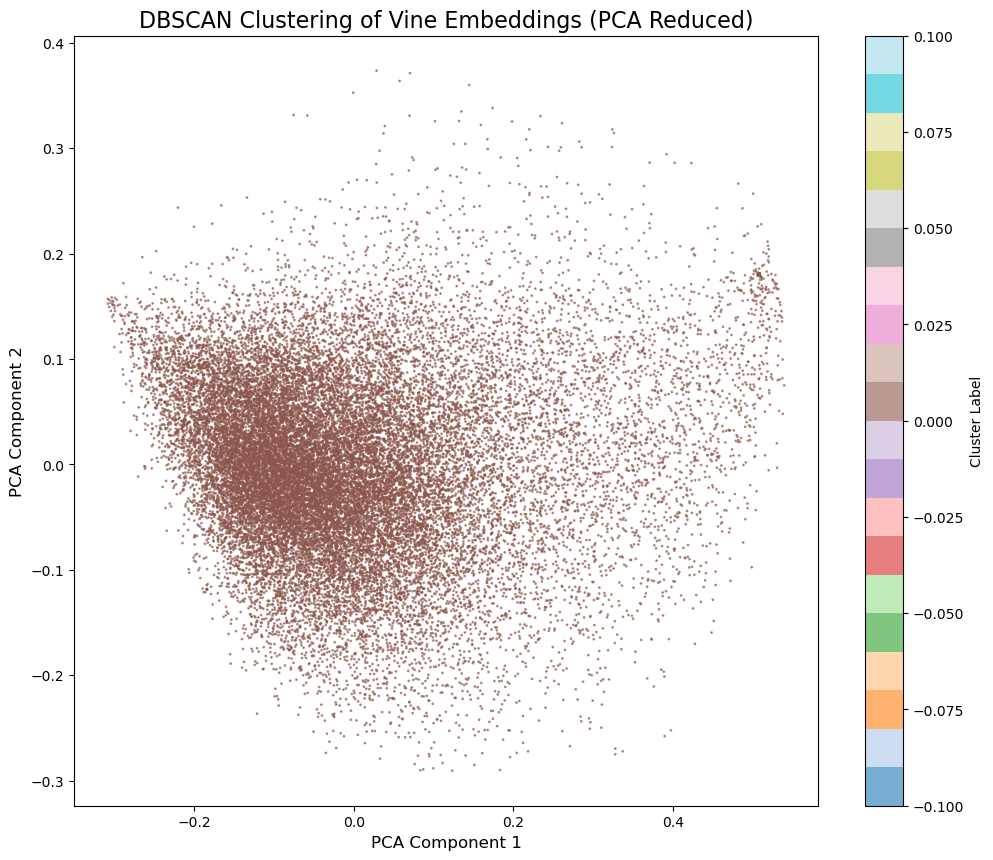

In [58]:
#TODO Plot DBSCAN clusters with t-SNE
df_reduced_dbscan = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
df_reduced_dbscan['cluster'] = dbscan_labels
plt.figure(figsize=FIG_SIZE)
scatter = plt.scatter(df_reduced_dbscan['PCA1'], df_reduced_dbscan['PCA2'], c=df_reduced_dbscan['cluster'], s=DOT_SIZE, cmap='tab20', alpha=0.6)
plt.title('DBSCAN Clustering of Vine Embeddings (PCA Reduced)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(scatter, label='Cluster Label')
plt.show() 

## Vine Selection

In [ ]:
#TODO Based on clustering results, create compilations of similar vines

## Compilation Creation

## Reflection Section